In [13]:
# load beir IR dataset
from datasets import load_dataset

corpus = load_dataset("BeIR/nq", "corpus", split="corpus")
queries = load_dataset("BeIR/nq", "queries", split="queries")

In [14]:
# load the corpus sample
corpus[0]

{'_id': 'doc0',
 'title': 'Minority interest',
 'text': "In accounting, minority interest (or non-controlling interest) is the portion of a subsidiary corporation's stock that is not owned by the parent corporation. The magnitude of the minority interest in the subsidiary company is generally less than 50% of outstanding shares, or the corporation would generally cease to be a subsidiary of the parent.[1]"}

In [15]:
# load the query sample
queries[0]

{'_id': 'test0',
 'title': '',
 'text': 'what is non controlling interest on balance sheet'}

In [16]:
# load the qrels split from beir
qrels = load_dataset("BeIR/nq-qrels", split="test")

# parse qrels into a dictionary
from collections import defaultdict
qrel_lookup = defaultdict(set)
for row in qrels:
    if row.get("score", 0) > 0:
        qrel_lookup[row["query-id"]].add(row["corpus-id"])

print("queries with relevance labels:", len(qrel_lookup))

queries with relevance labels: 3452


In [17]:
# check if cuda is supported
import torch
print("Device:", "cuda" if torch.cuda.is_available() else "cpu")

Device: cuda


In [35]:
from sentence_transformers import SentenceTransformer
import time

# model with 384 dimension vectors
# (intfloat/e5-small-v2) or (all-MiniLM-L6-v2)
EMBEDDING_MODEL = "all-MiniLM-L6-v2" # this model has better metrics compared to intfloat/e5-small-v2
embedder = SentenceTransformer(EMBEDDING_MODEL, device="cuda") # for faster processing

# prepare data for embeddings
query_ids = queries["_id"] 
query_texts = queries["text"]

qrels_dict = {}
for row in qrels:
    qid, docid, score = row["query-id"], row["corpus-id"], row["score"]
    qrels_dict.setdefault(qid, {})[docid] = score

# NOTE: we are embedding only 500k vectors
corpus_texts = [
    (title if title else "") + " " + (text if text else "")
    for title, text in zip(corpus["title"][:500000], corpus["text"][:500000])
]
corpus_ids = corpus["_id"][:500000]
corpus_ids_set = set(corpus_ids)

filtered_qrels_dict = {}
filtered_query_ids = []
filtered_query_texts = []

query_ids_set = set(query_ids)

for qid, doc_scores in qrels_dict.items():
    # skip qids not in queries dataset
    if qid not in query_ids_set:
        continue

    # keep only docs in the 500k corpus
    rel_docs_subset = {docid: score for docid, score in doc_scores.items() if docid in corpus_ids_set}
    if rel_docs_subset:
        filtered_qrels_dict[qid] = rel_docs_subset
        # add corresponding query text
        idx = query_ids.index(qid)
        filtered_query_ids.append(qid)
        filtered_query_texts.append(query_texts[idx])

query_ids = filtered_query_ids
query_texts = filtered_query_texts
qrels_dict = filtered_qrels_dict

print("corpus size:", len(corpus_ids))
print("queries size:", len(query_ids))
print("sample qrel:", list(qrels_dict.items())[:1])

corpus size: 500000
queries size: 3452
sample qrel: [('test0', {'doc0': 1, 'doc1': 1})]


In [36]:
import numpy as np
import os

corpus_file = "corpus_embeddings.npy"
if os.path.exists(corpus_file):
  print(f"loading cached corpus embeddings from {corpus_file}")
  corpus_embeddings = np.load(corpus_file)
else:
  # embed corpus texts
  print(f"encoding corpus with {EMBEDDING_MODEL}")
  t_corpus = time.time()
  corpus_embeddings = embedder.encode(corpus_texts, convert_to_numpy=True, show_progress_bar=True, batch_size=128)
  print(f"embedded in %2f sec" %(time.time()-t_corpus))

encoding corpus with all-MiniLM-L6-v2


Batches:   0%|          | 0/3907 [00:00<?, ?it/s]

embedded in 680.003049 sec


In [37]:
query_file = "query_embeddings.npy"
if os.path.exists(query_file):
  print(f"loading cached query embeddings from {query_file}")
  query_embeddings = np.load(query_file)
else:
  # embed queries texts
  print(f"encoding queries with {EMBEDDING_MODEL}")
  t_queries= time.time()
  query_embeddings = embedder.encode(query_texts, convert_to_numpy=True, show_progress_bar=True, batch_size=64)
  print(f"embedded in %2f sec" %(time.time()-t_queries))

encoding queries with all-MiniLM-L6-v2


Batches:   0%|          | 0/54 [00:00<?, ?it/s]

embedded in 1.095452 sec


In [38]:
# cache embeddings (optional)
np.save("corpus_embeddings.npy", corpus_embeddings)
np.save("query_embeddings.npy", query_embeddings)

In [39]:
dim = corpus_embeddings.shape[1]
dim

384

In [40]:
import faiss

# build FAISS index (float32)
index_flat = faiss.IndexFlatIP(dim)
faiss.normalize_L2(corpus_embeddings)
index_flat.add(corpus_embeddings)

In [41]:
# build binary quantized index
corpus_embeddings_bin = np.packbits((corpus_embeddings > 0).astype(np.uint8), axis=1)
index_bin = faiss.IndexBinaryFlat(corpus_embeddings_bin.shape[1]*8)
index_bin.add(corpus_embeddings_bin)

In [42]:
# retrieval
def retrieve(index, query_embeddings, top_k=10, binary=False):
  results = {}
  for i, qid in enumerate(query_ids):
    q_emb = query_embeddings[i:i+1]
    if not binary:
      faiss.normalize_L2(q_emb)
      D, I = index.search(q_emb, top_k)
    else:
      q_emb_bin = np.packbits((q_emb > 0).astype(np.uint8), axis=1)
      D, I = index.search(q_emb_bin, top_k)
    hits = {corpus_ids[int(idx)]: float(D[0][j]) for j, idx in enumerate(I[0])}
    results[qid] = hits
  return results

In [43]:
# run float retrieval
print("float index retrieval")
t_float_retrieval = time.time()
float_results = retrieve(index_flat, query_embeddings, top_k=10, binary=False)
print(f"float index retrieval completed for {len(query_embeddings)} queries in %2f sec" %(time.time()-t_float_retrieval))

float index retrieval
float index retrieval completed for 3452 queries in 135.995838 sec


In [44]:
# run binary retrieval
print("binary index retrieval")
t_binary_retrieval = time.time()
binary_results = retrieve(index_bin, query_embeddings, top_k=10, binary=True)
print(f"binary index retrieval completed for {len(query_embeddings)} queries in %2f sec" %(time.time()-t_binary_retrieval))

binary index retrieval
binary index retrieval completed for 3452 queries in 9.547602 sec


In [45]:
# print total vectors in both
print(f"total vectors in float index {len(corpus_embeddings)}")
print(f"total vectors in binary index {len(corpus_embeddings_bin)}")

total vectors in float index 500000
total vectors in binary index 500000


float index size: 732.42 MB
binary index size: 22.89 MB


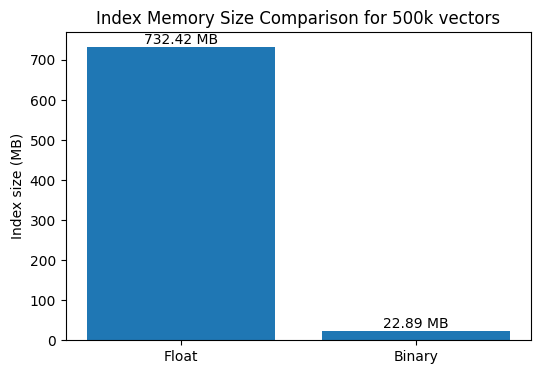

In [46]:
# index size comparison
import matplotlib.pyplot as plt

float_size = corpus_embeddings.nbytes / (1024 * 1024)
bin_size = corpus_embeddings_bin.nbytes / (1024 * 1024)

print(f"float index size: {float_size:.2f} MB")
print(f"binary index size: {bin_size:.2f} MB")

plt.figure(figsize=(6,4))
bars = plt.bar(["Float", "Binary"],[float_size, bin_size])
plt.ylabel("Index size (MB)")
plt.title(f"Index Memory Size Comparison for 500k vectors")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f} MB", ha='center', va='bottom')

plt.show()

In [54]:
# query latency, recall@k, ndcg@k evaluation

TOP_K = 10
# query latency comparison
search_times_float, search_times_bin = [], []
# recall@k comparison
recall_float, recall_bin = [], []

# ndcg@k comparison
ndcgs_float, ndcgs_bin = [], []
def ndcg(retrieved, relevant_docs, k=10):
    dcg = 0.0
    for i, doc_id in enumerate(retrieved[:k]):
        rel = relevant_docs.get(doc_id, 0) if isinstance(relevant_docs, dict) else int(doc_id in relevant_docs)
        dcg += (2**rel-1) / np.log2(i+2)
    ideal_rel = sorted([int(doc in relevant_docs) if isinstance(relevant_docs, set) else relevant_docs[doc] for doc in retrieved[:k]], reverse=True)
    idcg = sum((2**rel-1)/np.log2(idx+2) for idx,rel in enumerate(ideal_rel))
    return dcg/idcg if idcg>0 else 0

for i, q_emb in enumerate(query_embeddings):
    q = q_emb.reshape(1, -1)
    qid = query_ids[i]
    relevant_docs = set(qrels_dict.get(qid, {}).keys())
    
    # float search
    start = time.time()
    _, I_f = index_flat.search(q, TOP_K)
    search_times_float.append(time.time() - start)
    retrieved_f = [corpus_ids[idx] for idx in I_f[0]]
    recall_f = len(set(retrieved_f) & relevant_docs) / len(relevant_docs) if relevant_docs else 0
    recall_float.append(recall_f)
    ndcgs_float.append(ndcg(retrieved_f, relevant_docs, k=TOP_K))
    
    # binary search
    q_bin = np.packbits((q > 0).astype(np.uint8), axis=1)
    start = time.time()
    _, I_b = index_bin.search(q_bin, TOP_K)
    search_times_bin.append(time.time() - start)
    retrieved_b = [corpus_ids[idx] for idx in I_b[0]]
    recall_b = len(set(retrieved_b) & relevant_docs) / len(relevant_docs) if relevant_docs else 0
    recall_bin.append(recall_b)
    ndcgs_bin.append(ndcg(retrieved_b, relevant_docs, k=TOP_K))

# average latency
avg_flat_latency = np.mean(search_times_float)
avg_bin_latency = np.mean(search_times_bin)
print(f"avg float latency: {avg_flat_latency*1000:.2f} ms/query")
print(f"avg binary latency: {avg_bin_latency*1000:.2f} ms/query")

# average recall@k
avg_recall_float = np.mean(recall_float)
avg_recall_bin = np.mean(recall_bin)
print(f"avg recall@TOP_K={TOP_K} float: {avg_recall_float:.3f}")
print(f"avg recall@TOP_K={TOP_K} binary: {avg_recall_bin:.3f}")

# average nDCG
avg_ndcg_float = np.mean(ndcgs_float)
avg_ndcg_bin = np.mean(ndcgs_bin)
print(f"avg nDCG@TOP_K={TOP_K} float: {avg_ndcg_float:.3f}")
print(f"avg nDCG@TOP_K={TOP_K} binary: {avg_ndcg_bin:.3f}")

avg float latency: 38.55 ms/query
avg binary latency: 2.84 ms/query
avg recall@TOP_K=10 float: 0.746
avg recall@TOP_K=10 binary: 0.683
avg nDCG@TOP_K=10 float: 0.539
avg nDCG@TOP_K=10 binary: 0.480


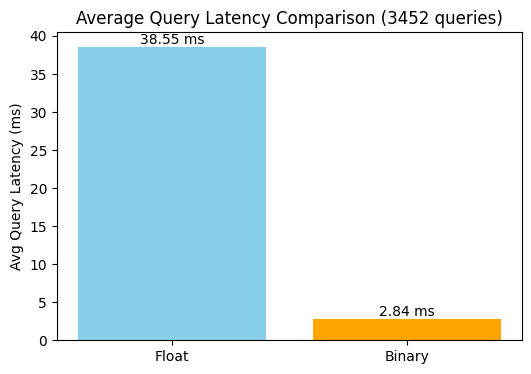

In [59]:
# plot chart for avg query latency
plt.figure(figsize=(6,4))
bars = plt.bar(["Float", "Binary"], [avg_flat_latency*1000, avg_bin_latency*1000], color=["skyblue", "orange"])
plt.ylabel("Avg Query Latency (ms)")
plt.title(f"Average Query Latency Comparison ({len(query_embeddings)} queries)")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f} ms", ha='center', va='bottom')

plt.show()

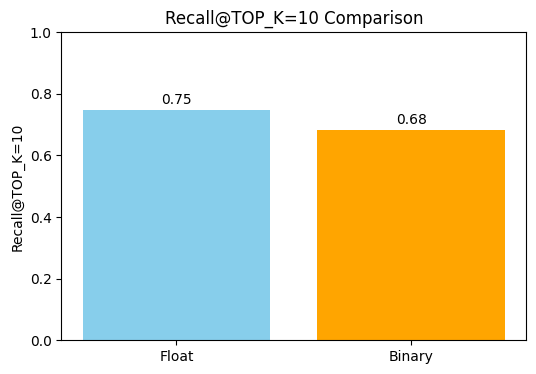

In [60]:
# plot chart for recall@k
plt.figure(figsize=(6,4))
bars = plt.bar(["Float", "Binary"], [avg_recall_float, avg_recall_bin], color=["skyblue", "orange"])
plt.ylabel(f"Recall@TOP_K={TOP_K}")
plt.title(f"Recall@TOP_K={TOP_K} Comparison")
plt.ylim(0,1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f"{height:.2f}", ha='center', va='bottom')

plt.show()

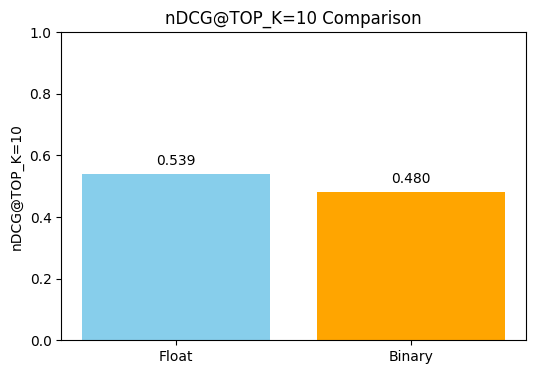

In [62]:
# plot chart for ndcg@k
plt.figure(figsize=(6,4))
bars = plt.bar(["Float", "Binary"], [avg_ndcg_float, avg_ndcg_bin], color=["skyblue", "orange"])
plt.ylim(0,1)
plt.ylabel(f"nDCG@TOP_K={TOP_K}")
plt.title(f"nDCG@TOP_K={TOP_K} Comparison")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.02, f"{height:.3f}", ha='center', va='bottom')

plt.show()